<a href="https://colab.research.google.com/github/DimaKav/python-marketing-projects/blob/master/Data_Science_for_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Descriptive Analysis - Visualizing KPIs

Dataset description: https://archive.ics.uci.edu/ml/datasets/bank+marketing

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/DimaKav/python-marketing-projects/master/bank-full.csv', sep=';')

In [3]:
df.shape

(45211, 17)

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


y - has the client subscribed a term deposit? (binary: 'yes','no')

In [0]:
# Encode the y
labels, uniques = pd.factorize(df['y'])
df['conversion'] = labels

In [6]:
# Aggregate conversion rate: overall performance of our marketing campaign

print('total conversions: %i out of %i' % (df.conversion.sum(), df.shape[0]))
print('conversion rate: %0.2f%%' % (df.conversion.sum() / df.shape[0] * 100.0))

total conversions: 5289 out of 45211
conversion rate: 11.70%


Let's dive deeper and break the customer base into multiple segments by age and compute KPIs for individual segments.

In [0]:
conversions_by_age = df.groupby(
    by='age'
)['conversion'].sum() / df.groupby(
    by='age'
)['conversion'].count() * 100.0

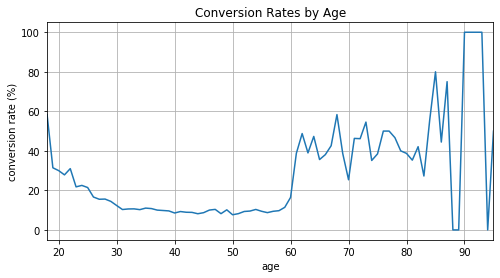

In [8]:
ax = conversions_by_age.plot(
    grid=True,
    figsize=(8, 4),
    title='Conversion Rates by Age'
)

ax.set_xlabel('age')
ax.set_ylabel('conversion rate (%)')

plt.show()

There aren't many clients who are 80 or older so that data is noisy on the chart. To reduce the noise, we can group multiple ages together.

In [0]:
df['age_group'] = df['age'].apply(
    lambda x: '[18, 30)' if x < 30 else '[30, 40)' if x < 40 \
        else '[40, 50)' if x < 50 else '[50, 60)' if x < 60 \
        else '[60, 70)' if x < 70 else '70+'
)

In [0]:
conversions_by_age_group = df.groupby(
    by='age_group'
)['conversion'].sum() / df.groupby(
    by='age_group'
)['conversion'].count() * 100.0

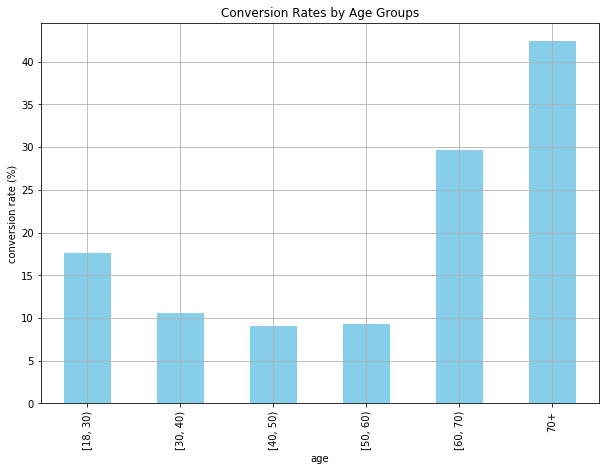

In [11]:
ax = conversions_by_age_group.loc[
    ['[18, 30)', '[30, 40)', '[40, 50)', '[50, 60)', '[60, 70)', '70+']
].plot(
    kind='bar',
    color='skyblue',
    grid=True,
    figsize=(10, 7),
    title='Conversion Rates by Age Groups'
)

ax.set_xlabel('age')
ax.set_ylabel('conversion rate (%)')

plt.show()

Let's look at the demographic differences between the converted clients and the non-converted clients.

In [0]:
conversions_by_marital_status_df = pd.pivot_table(df, values='y', 
                                               index='marital', 
                                               columns='conversion', 
                                               aggfunc=len)

In [0]:
conversions_by_marital_status_df.rename(columns={0: 'non-conversion'}, inplace=True)
conversions_by_marital_status_df.rename(columns={1: 'conversion'}, inplace=True)

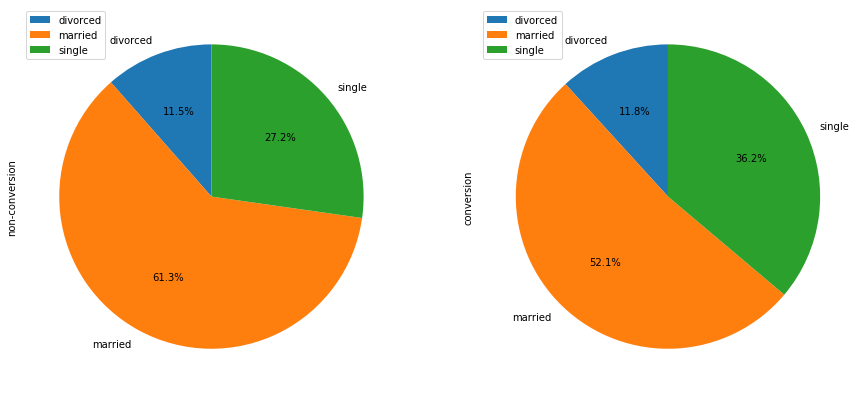

In [14]:
conversions_by_marital_status_df.plot(
    kind='pie',
    figsize=(15, 7),
    startangle=90,
    subplots=True,
    autopct=lambda x: '%0.1f%%' % x
)

plt.show()

Let's look at conversions by age and marital status.

In [0]:
age_marital_df = df.groupby(['age_group', 'marital'])['conversion'].sum().unstack('marital').fillna(0)

age_marital_df = age_marital_df.divide(
    df.groupby(
        by='age_group'
    )['conversion'].count(),
    axis=0
)

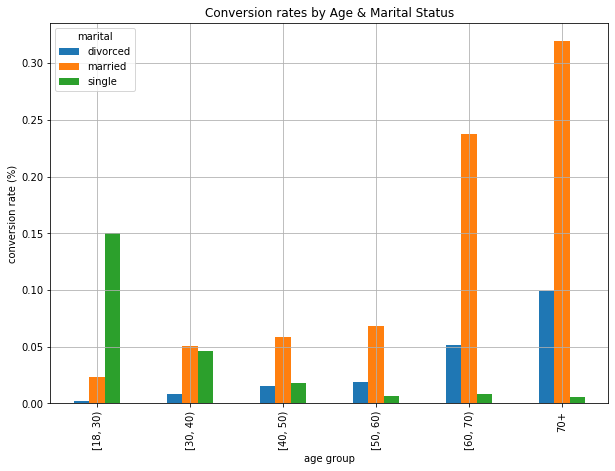

In [16]:
ax = age_marital_df.loc[
    ['[18, 30)', '[30, 40)', '[40, 50)', '[50, 60)', '[60, 70)', '70+']
].plot(
    kind='bar', 
    grid=True,
    figsize=(10,7)
)

ax.set_title('Conversion rates by Age & Marital Status')
ax.set_xlabel('age group')
ax.set_ylabel('conversion rate (%)')

plt.show()

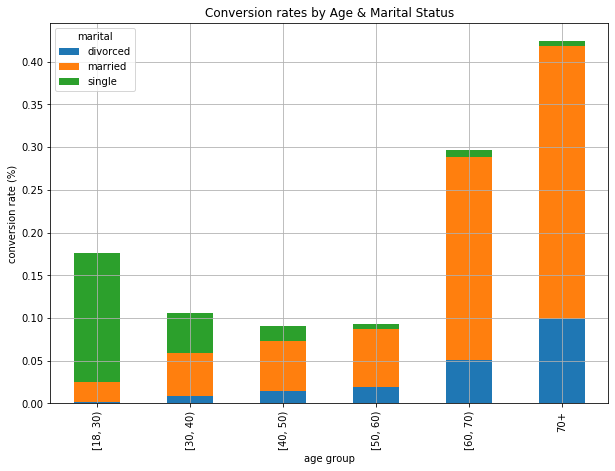

In [17]:
ax = age_marital_df.loc[
    ['[18, 30)', '[30, 40)', '[40, 50)', '[50, 60)', '[60, 70)', '70+']
].plot(
    kind='bar', 
    stacked=True,
    grid=True,
    figsize=(10,7)
)

ax.set_title('Conversion rates by Age & Marital Status')
ax.set_xlabel('age group')
ax.set_ylabel('conversion rate (%)')

plt.show()

# Customer Engagement 

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/DimaKav/python-marketing-projects/master/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')

In [19]:
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [20]:
df.shape

(9134, 24)

In [0]:
# Encode the response column
labels, uniques = pd.factorize(df['Response'])
df['Engaged'] = labels

In [0]:
# Agg engagement rate
engagement_rate_df = pd.DataFrame(
    df.groupby('Engaged').count()['Response'] / df.shape[0] * 100.0
)

In [23]:
engagement_rate_df.T

Engaged,0,1
Response,85.679877,14.320123


~85% of the customers have not responded to marketing calls. Let's look at engagement per sales channel.

In [0]:
engagement_by_sales_channel_df = pd.pivot_table(
    df, values='Response', index='Sales Channel', columns='Engaged', aggfunc=len
).fillna(0.0)

engagement_by_sales_channel_df.columns = ['Not Engaged', 'Engaged']

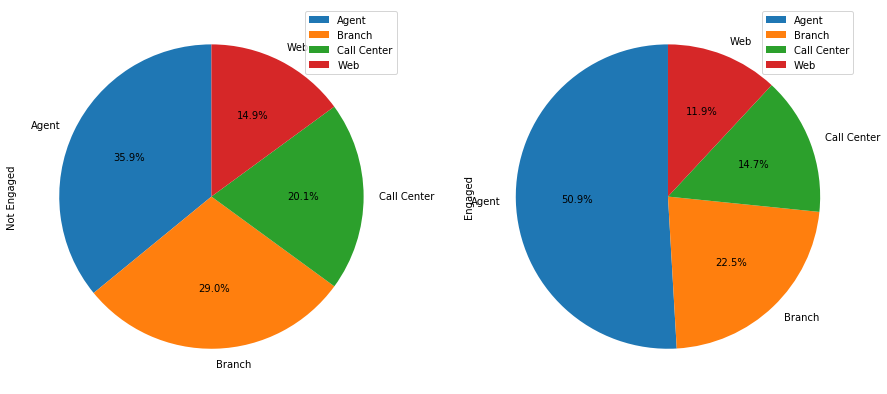

In [25]:
engagement_by_sales_channel_df.plot(
    kind='pie',
    figsize=(15, 7),
    startangle=90,
    subplots=True,
    autopct=lambda x: '%0.1f%%' % x
)

plt.show()

Now let's looks at total claim amount.

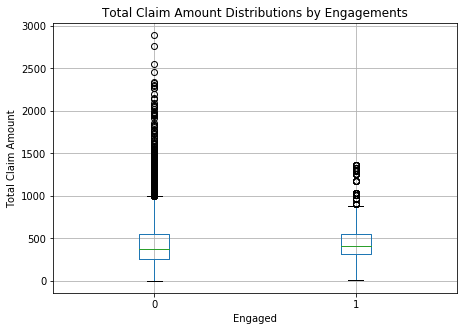

In [26]:
ax = df[['Engaged', 'Total Claim Amount']].boxplot(
    by='Engaged',
    showfliers=True,
    figsize=(7,5)
)

ax.set_xlabel('Engaged')
ax.set_ylabel('Total Claim Amount')
ax.set_title('Total Claim Amount Distributions by Engagements')

plt.suptitle("")
plt.show()

# Regression Analysis of Engagement

In [0]:
continuous_vars = [
    'Customer Lifetime Value', 'Income', 'Monthly Premium Auto', 
    'Months Since Last Claim', 'Months Since Policy Inception', 
    'Number of Open Complaints', 'Number of Policies', 
    'Total Claim Amount' 
]

logit = sm.Logit(
    df['Engaged'],
    df[continuous_vars]
)

In [28]:
logit_fit = logit.fit()

Optimization terminated successfully.
         Current function value: 0.421189
         Iterations 6


In [29]:
logit_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Engaged   No. Observations:                 9134
Model:                          Logit   Df Residuals:                     9126
Method:                           MLE   Df Model:                            7
Date:                Sat, 26 Oct 2019   Pseudo R-squ.:                -0.02546
Time:                        12:23:41   Log-Likelihood:                -3847.1
converged:                       True   LL-Null:                       -3751.6
Covariance Type:            nonrobust   LLR p-value:                     1.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Customer Lifetime Value       -6.741e-06   5.04e-06     -1.337      0.181   -1.66e-05    3.14e-06
Income                        -2.857e-06   1.03e-06     -2.766      0.006   -4.88e-06   -8.33e-07
Monthly Premium Auto             -0.0084      0.001     -6.889      0.000      -0.011      -0.006
Months Since Last Claim          -0.0202      0.003     -7.238      0.000      -0.026      -0.015
Months Since Policy Inception    -0.0060      0.001     -6.148      0.000      -0.008      -0.004
Number of Open Complaints        -0.0829      0.034     -2.424      0.015      -0.150      -0.016
Number of Policies               -0.0810      0.013     -6.356      0.000      -0.106      -0.056
Total Claim Amount                0.0001      0.000      0.711      0.477      -0.000       0.000
=================================================================================================
"""

In [30]:
# Factorize the rest of the variables and run the regression again

gender_values, gender_labels = df['Gender'].factorize()

categories = pd.Categorical(
    df['Education'], 
    categories=['High School or Below', 'Bachelor', 'College', 'Master', 'Doctor']
)

df['GenderFactorized'] = gender_values
df['EducationFactorized'] = categories.codes

logit = sm.Logit(
    df['Engaged'], 
    df[[
        'GenderFactorized',
        'EducationFactorized'
    ]]
)

logit_fit = logit.fit()

logit_fit.summary()

Optimization terminated successfully.
         Current function value: 0.493068
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Engaged   No. Observations:                 9134
Model:                          Logit   Df Residuals:                     9132
Method:                           MLE   Df Model:                            1
Date:                Sat, 26 Oct 2019   Pseudo R-squ.:                 -0.2005
Time:                        12:23:41   Log-Likelihood:                -4503.7
converged:                       True   LL-Null:                       -3751.6
Covariance Type:            nonrobust   LLR p-value:                     1.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
GenderFactorized       -1.1266      0.047    -24.116      0.000      -1.218      -1.035
EducationFactorized    -0.6256      0.021    -29.900      0.000      -0.667      -0.585
=======================================================================================
"""

In [32]:
# Combine continuous and categorical
logit = sm.Logit(
    df['Engaged'], 
    df[['Customer Lifetime Value',
        'Income',
        'Monthly Premium Auto',
        'Months Since Last Claim',
        'Months Since Policy Inception',
        'Number of Open Complaints',
        'Number of Policies',
        'Total Claim Amount',
        'GenderFactorized',
        'EducationFactorized'
    ]]
)

logit_fit = logit.fit()

logit_fit.summary()

Optimization terminated successfully.
         Current function value: 0.420810
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Engaged   No. Observations:                 9134
Model:                          Logit   Df Residuals:                     9124
Method:                           MLE   Df Model:                            9
Date:                Sat, 26 Oct 2019   Pseudo R-squ.:                -0.02454
Time:                        12:24:17   Log-Likelihood:                -3843.7
converged:                       True   LL-Null:                       -3751.6
Covariance Type:            nonrobust   LLR p-value:                     1.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Customer Lifetime Value       -6.909e-06   5.03e-06     -1.373      0.170   -1.68e-05    2.96e-06
Income                         -2.59e-06   1.04e-06     -2.494      0.013   -4.63e-06   -5.55e-07
Monthly Premium Auto             -0.0081      0.001     -6.526      0.000      -0.011      -0.006
Months Since Last Claim          -0.0194      0.003     -6.858      0.000      -0.025      -0.014
Months Since Policy Inception    -0.0057      0.001     -5.827      0.000      -0.008      -0.004
Number of Open Complaints        -0.0813      0.034     -2.376      0.017      -0.148      -0.014
Number of Policies               -0.0781      0.013     -6.114      0.000      -0.103      -0.053
Total Claim Amount                0.0001      0.000      0.943      0.346      -0.000       0.000
GenderFactorized                 -0.1500      0.058     -2.592      0.010      -0.263      -0.037
EducationFactorized              -0.0070      0.027     -0.264      0.792      -0.059       0.045
=================================================================================================
"""